# SFO weather prediction

This notebook was written and executed using Google Colab.

Here we use historical weather data from a weather station at San Francisco International Airport (SFO) to see if we can predict weather at a daily resolution using this historical data alone. In particular, we will be using a special type of recurrent neural network (RNN) called long short-term memory (LSTM) to make these predictions.

Data was downloaded from the National Climatic Data Center: https://www.ncdc.noaa.gov/cdo-web/datasets#GHCND

Full documentation of the data can be found either at the website above, or in `GHCND_documentation.pdf` within this repository.

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# machine learning modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%tensorflow_version 2.x
import tensorflow as tf

# apparently this is needed now...
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

TensorFlow 2.x selected.


In [2]:
tf.__version__

'2.1.0'

## Clean Data

Import data from the GitHub repository:

In [3]:
data_url = 'https://raw.githubusercontent.com/yuempark/SFO-weather-prediction/master/SFO-weather.csv?token=ADI6VJ4TLL2SDMTMW7JUXXS6JXQWI'

data = pd.read_csv(data_url)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27213 entries, 0 to 27212
Data columns (total 90 columns):
STATION            27213 non-null object
NAME               27213 non-null object
LATITUDE           27213 non-null float64
LONGITUDE          27213 non-null float64
ELEVATION          27213 non-null float64
DATE               27213 non-null object
ACMH               11585 non-null float64
ACMH_ATTRIBUTES    11585 non-null object
ACSH               11590 non-null float64
ACSH_ATTRIBUTES    11590 non-null object
AWND               13187 non-null float64
AWND_ATTRIBUTES    13187 non-null object
FMTM               10182 non-null float64
FMTM_ATTRIBUTES    10182 non-null object
FRGT               3 non-null float64
FRGT_ATTRIBUTES    3 non-null object
PGTM               22521 non-null float64
PGTM_ATTRIBUTES    22521 non-null object
PRCP               27211 non-null float64
PRCP_ATTRIBUTES    27211 non-null object
SNOW               19489 non-null float64
SNOW_ATTRIBUTES    19489 no

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,9,11,13,15,25,31,33,35,37,39,41,43,45,47,49,51,53,61,65,69,71,73,75,77,81,83,85,87,89) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Get rid of features that don't contain any reasonable amount of data:

In [0]:
del_cols = []

for i in range(len(data.columns)):
    if np.sum(~pd.isnull(data[data.columns[i]])) < 5000:
        del_cols.append(data.columns[i])

data.drop(del_cols, axis=1, inplace=True)

A brief description of the attributes that we are left with:

| Feature | Description |
|---------|-------------|
|ACMH|Average cloudiness midnight to midnight from manual observations (percent)|
|ACSH|Average cloudiness sunrise to sunset from manual observations (percent)|
|AWND|Average daily wind speed (meters per second)|
|FMTM|Time of fastest mile or fastest 1-minute wind (hours and minutes, i.e., HHMM)|
|PGTM|Peak gust time (hours and minutes, i.e., HHMM)|
|PRCP|Precipitation (mm)
|SNOW|Snowfall (mm)|
|SNWD|Snow depth (mm)|
|TAVG|Average temperature (Celsius)|
|TMAX|Maximum temperature (Celsius)|
|TMIN|Minimum temperature (Celsius)|
|WDF1|Direction of fastest 1-minute wind (degrees)|
|WDF2|Direction of fastest 2-minute wind (degrees)|
|WDF5|Direction of fastest 5-second wind (degrees)|
|WDFG|Direction of peak wind gust (degrees)|
|WESD|Water equivalent of snow on the ground (mm)|
|WSF1|Fastest 1-minute wind speed (meters per second)|
|WSF2|Fastest 2-minute wind speed (meters per second)|
|WSF5|Fastest 5-second wind speed (meters per second)|
|WSFG|Peak guest wind speed (meters per second)|
|WT01|Fog, ice fog, or freezing fog (may include heavy fog)|
|WT08|Smoke or haze|
|WT16|Rain (may include freezing rain, drizzle, and freezing drizzle)|

### Select Time Slice

Now plot where each of the attributes have data:

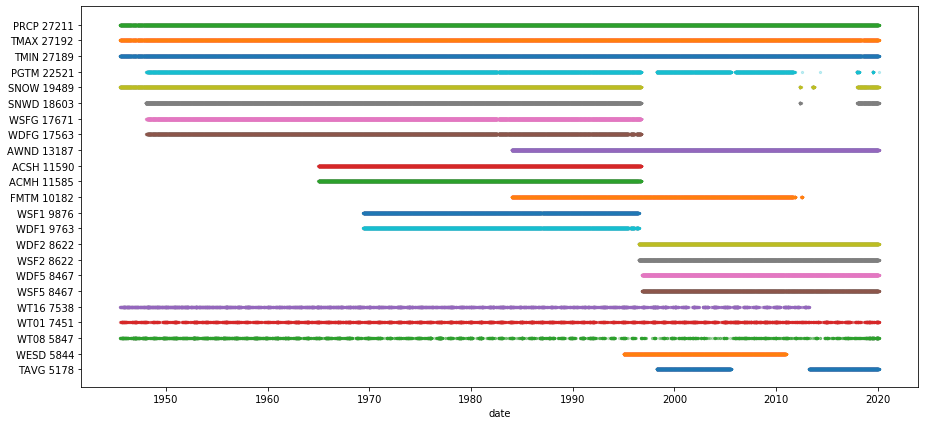

In [5]:
# convert the date column to datetime
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')

# pull out the time series data, and ignore the attribute columns for now
feature_cols = []
for i in range(6, len(data.columns)):
    if 'ATTRIBUTES' not in data.columns[i]:
        feature_cols.append(data.columns[i])

# sort these features by number of non-null cells
n_non_null = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
    n_non_null[i] = np.sum(~pd.isnull(data[feature_cols[i]]))
non_null_sort_inds = np.argsort(n_non_null)
n_non_null = n_non_null[non_null_sort_inds]
feature_cols[:] = [feature_cols[i] for i in non_null_sort_inds]

fig, ax = plt.subplots(figsize=(15,7))
yticklabels = []

# iterate through the feature columns
for i in range(len(feature_cols)):
    
    # create a simple data present/not present mask
    data_mask_bool = ~pd.isnull(data[feature_cols[i]])
    data_mask_int = np.zeros(len(data_mask_bool))
    data_mask_int[data_mask_bool] = 1
    data_mask_int[~data_mask_bool] = np.nan

    # plot it
    ax.scatter(data['DATE'], data_mask_int+i-1, alpha=0.25, s=5)

    yticklabels.append(feature_cols[i] + ' ' + str(int(n_non_null[i])))

# prettify
ax.set_xlabel('date')
ax.set_yticks(range(len(feature_cols)))
ax.set_yticklabels(yticklabels)

plt.show(fig)

There seems to have been a switch in the method of data collection sometime in the mid-1990's, during which time they stopped collecting certain types of data, and started collecting others. Since we're interested in making predictions looking forward, we'll restrict the rest of this analysis to only use data after the mid-1990's data collection switch.

Limiting the analysis to data after the mid-1990's also has the added benefit of limiting (albeit not removing) the possible complication of large-scale changes in the climate system due to continued and prolonged global warming.

Let's pull out that data and clean it up:

In [6]:
# select the features based on the figure above
features = ['PRCP','TMAX','TMIN','AWND','WDF2','WSF2','WDF5','WSF5','WT01','WT08']
attributes = ['DATE','PRCP_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','AWND_ATTRIBUTES',
              'WDF2_ATTRIBUTES','WSF2_ATTRIBUTES','WDF5_ATTRIBUTES','WSF5_ATTRIBUTES','WT01_ATTRIBUTES','WT08_ATTRIBUTES']
data_features = data[features].copy()
data_attributes = data[attributes].copy()

# find where the data starts for WDF5 (the feature that starts the latest)
start_date = np.min(data_attributes[~pd.isnull(data_features['WDF5'])]['DATE'])

# slice the data
data_features = data_features[data_attributes['DATE']>=start_date]
data_attributes = data_attributes[data_attributes['DATE']>=start_date]

# there are no observations for the last day of the dataset
data_features.drop(data_features.tail(1).index, axis=0, inplace=True)
data_attributes.drop(data_attributes.tail(1).index, axis=0, inplace=True)

# reset indexes
data_features.reset_index(drop=True, inplace=True)
data_attributes.reset_index(drop=True, inplace=True)

# change nan's to zeros in the fog and smoke features
data_features.loc[np.isnan(data_features['WT01']), 'WT01'] = 0
data_features.loc[np.isnan(data_features['WT08']), 'WT08'] = 0

# in the attributes columns, the second value is the quality flag
# any value here indicates that the measurement failed a quality assurance check, so let's get rid of them
bad_observations = []
for i in range(len(data_features)):
    for j in range(len(features)):
        if type(data_attributes[features[j]+'_ATTRIBUTES'][i])==str:
            if len(data_attributes[features[j]+'_ATTRIBUTES'][i].split(',')[1]) != 0:
                data_features[features[j]][i] = np.nan
                bad_observations.append('{},'.format(i) + features[j])
print(bad_observations)

['365,WSF2', '2310,AWND']


### Impute

Is missing data a problem?

In [7]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 10 columns):
PRCP    8500 non-null float64
TMAX    8480 non-null float64
TMIN    8480 non-null float64
AWND    8498 non-null float64
WDF2    8499 non-null float64
WSF2    8498 non-null float64
WDF5    8467 non-null float64
WSF5    8467 non-null float64
WT01    8500 non-null float64
WT08    8500 non-null float64
dtypes: float64(10)
memory usage: 664.2 KB


Fortunately there aren't many missing values, but they still do exist, so we're going to have to impute for our methods to work correctly.

There are many viable approaches to imputing data. The approach that we will take here is to create a fake dataset in which we have randomly removed some data, impute using various methods on the fake dataset, then compare the results to the real dataset. We'll then select the method that performed the best on the fake dataset (measured simply by RMSE) to impute the data that we actually need.

Note that a balance needs to be struck when deciding how much data to remove when creating our fake dataset. If we remove too much data, then we won't be accurately representing the true imputation that will need to be performed since only a small number of data points are actually missing in the true dataset (i.e. there will be high bias). However, if we don't remove enough, our RMSE will likely be highly sensitive to the particular points chosen to be removed (i.e. there will be high variance). We can "take the best of both worlds" by applying a cross-validation approach, in which we remove some data points, impute, compute the RMSE, replace the originally removed data points, then repeat. After many repetitions, we can take the mean of the RMSE's computed at each fold to estimate which method is likely to perform the best for the data that we actually need.

In [8]:
# the columns and methods for imputing
impute_cols = ['TMAX','TMIN','AWND','WDF2','WSF2','WDF5','WSF5']
impute_methods = ['pad','linear','akima','cubic']
impute_col_methods = []
for col in impute_cols:
    for method in impute_methods:
        impute_col_methods.append(col + '_' + method)

# set up a dataframe to store our results
n_remove_inds = 50
n_folds = 1000
np.random.seed(2020)
impute_cv_results = pd.DataFrame(columns=impute_col_methods, index=np.arange(n_folds), dtype=float)

# iterate through the folds
for i in range(n_folds):

    # iterate through the columns
    for col in impute_cols:
        
        # randomly pick values to remove, avoiding the edges of the data to avoid extrapolation issues
        remove_inds = np.random.choice(np.arange(1, len(data_features)-1), size=n_remove_inds, replace=False)
        fake_col = data_features[col].copy()
        fake_col[remove_inds] = np.nan

        # impute using various methods
        fake_col_pad = fake_col.interpolate(method='pad')
        fake_col_linear = fake_col.interpolate(method='linear')
        fake_col_akima = fake_col.interpolate(method='akima')
        fake_col_cubic = fake_col.interpolate(method='cubic')

        # the original data that was removed
        imputed_label = data_features[col][remove_inds]

        # the values that were imputed
        imputed_prediction_pad = fake_col_pad[remove_inds]
        imputed_prediction_linear = fake_col_linear[remove_inds]
        imputed_prediction_akima = fake_col_akima[remove_inds]
        imputed_prediction_cubic = fake_col_cubic[remove_inds]

        # we might have accidentally picked some NaNs in the real data - get rid of them
        imputed_prediction_pad = imputed_prediction_pad[np.isfinite(imputed_label)]
        imputed_prediction_linear = imputed_prediction_linear[np.isfinite(imputed_label)]
        imputed_prediction_akima = imputed_prediction_akima[np.isfinite(imputed_label)]
        imputed_prediction_cubic = imputed_prediction_cubic[np.isfinite(imputed_label)]
        imputed_label = imputed_label[np.isfinite(imputed_label)]

        # compute the RMSE's and store
        impute_cv_results[col + '_pad'][i] = mean_squared_error(imputed_label, imputed_prediction_pad, squared=False)
        impute_cv_results[col + '_linear'][i] = mean_squared_error(imputed_label, imputed_prediction_linear, squared=False)
        impute_cv_results[col + '_akima'][i] = mean_squared_error(imputed_label, imputed_prediction_akima, squared=False)
        impute_cv_results[col + '_cubic'][i] = mean_squared_error(imputed_label, imputed_prediction_cubic, squared=False)

impute_cv_results.describe()

,TMAX_pad,TMAX_linear,TMAX_akima,TMAX_cubic,TMIN_pad,TMIN_linear,TMIN_akima,TMIN_cubic,AWND_pad,AWND_linear,AWND_akima,AWND_cubic,WDF2_pad,WDF2_linear,WDF2_akima,WDF2_cubic,WSF2_pad,WSF2_linear,WSF2_akima,WSF2_cubic,WDF5_pad,WDF5_linear,WDF5_akima,WDF5_cubic,WSF5_pad,WSF5_linear,WSF5_akima,WSF5_cubic
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.789044,2.073185,2.086859,2.247850,1.602559,1.223943,1.251419,1.374636,1.752017,1.362209,1.383118,1.503251,72.185863,60.666187,62.395682,72.281940,3.124178,2.523155,2.601549,2.953818,71.891666,60.841093,62.587716,73.621095,3.871261,3.130027,3.226898,3.661417
std,0.396672,0.273464,0.276424,0.286188,0.195566,0.156918,0.159858,0.173645,0.235555,0.192932,0.193188,0.204592,14.403754,11.947708,12.561242,14.566644,0.522632,0.442514,0.449819,0.502344,14.789341,12.225603,12.808845,14.645357,0.563990,0.462030,0.475353,0.509598
min,1.472815,1.238023,1.286542,1.415079,0.935094,0.766290,0.825409,0.818154,1.070701,0.841309,0.874443,0.955446,31.874755,28.008927,28.825682,35.985136,2.059466,1.605101,1.563115,1.703735,27.166155,23.558438,24.592915,27.065663,2.468413,1.966323,2.034372,2.225093
25%,2.499948,1.887084,1.897441,2.053081,1.460342,1.109392,1.136670,1.250645,1.593016,1.231523,1.258406,1.359944,62.769419,52.325901,53.877866,61.851177,2.797467,2.251461,2.319933,2.623713,61.510161,51.940038,53.513153,63.317525,3.477564,2.789215,2.894054,3.288450
50%,2.770866,2.077829,2.090437,2.234273,1.593267,1.220738,1.251536,1.368028,1.736951,1.345019,1.370103,1.488396,72.062470,60.234957,61.800139,71.438262,3.086616,2.468699,2.553986,2.909377,71.851462,60.658195,62.228249,73.419637,3.829896,3.102866,3.196308,3.645532
75%,3.049156,2.258761,2.274709,2.432357,1.743187,1.325271,1.353468,1.494689,1.898473,1.486555,1.507794,1.633424,81.663945,68.837569,70.639024,81.117628,3.384199,2.741301,2.828005,3.184817,81.847413,69.335224,71.471889,83.131143,4.238165,3.429768,3.553416,3.985154
max,4.200714,3.087629,3.035313,3.295175,2.244638,1.708040,1.849058,1.947835,2.593183,2.109606,2.183306,2.486785,126.783280,101.408141,105.537638,120.664184,6.576154,5.931534,6.004858,6.249596,120.016666,100.604285,102.213956,119.234024,5.993179,4.793098,4.863906,5.495756


Plot these cross validation results normalized to the scale of each feature:

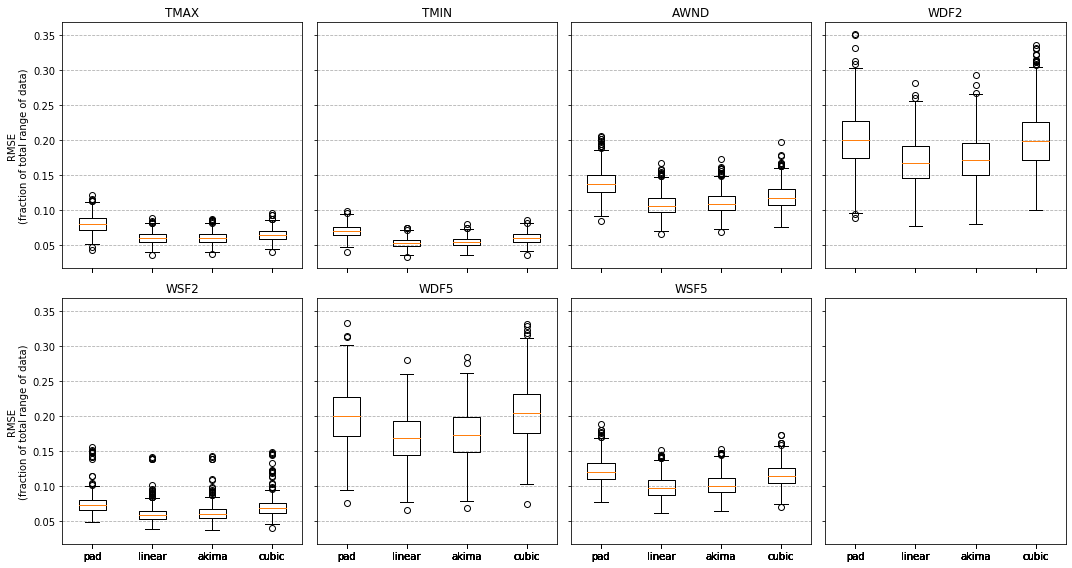

In [9]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(15,8), sharex=True, sharey=True)

ax = ax.flatten()

for i in range(len(impute_cols)):
    data_range = np.nanmax(data_features[impute_cols[i]]) - np.nanmin(data_features[impute_cols[i]])
    ax[i].boxplot([impute_cv_results[impute_cols[i]+'_pad']/data_range,
                   impute_cv_results[impute_cols[i]+'_linear']/data_range,
                   impute_cv_results[impute_cols[i]+'_akima']/data_range,
                   impute_cv_results[impute_cols[i]+'_cubic']/data_range],
                  labels=impute_methods)
    ax[i].set_title(impute_cols[i])
    ax[i].yaxis.grid(ls='--')

ax[0].set_ylabel('RMSE\n(fraction of total range of data)')
ax[4].set_ylabel('RMSE\n(fraction of total range of data)')

fig.tight_layout()
plt.show(fig)

The simple linear interpolation method performs the best for all features.

If we look more closely at the results, we can see that the linear interpolation method produces reasonable predictions for the temperature data (accurate to within 10%) and the wind speed data (accurate to within 15% in most cases). However, the predictions for the wind direction data are often up to 30% wrong.

We can attribute this to two main factors. First, the wind direction data is discretized to multiples of 10, so any continuous interpolation will often inherently create an "incorrect" prediction. Second, there is the "circular problem" (that 0 is the same as 360) associated with directional data that we do not account for. Here we can plot histograms of the wind direction data to illustrate these points:

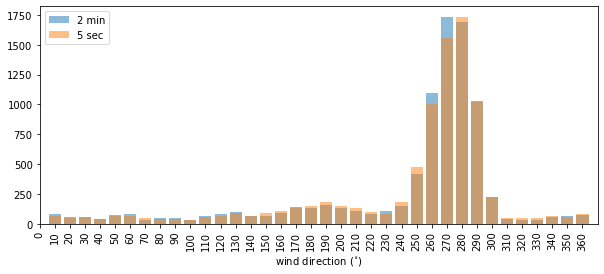

In [10]:
fig, ax = plt.subplots(figsize=(10,4))

WDF2_directions, WDF2_counts = np.unique(data_features['WDF2'], return_counts=True)
WDF5_directions, WDF5_counts = np.unique(data_features['WDF5'], return_counts=True)

ax.bar(np.arange(len(WDF2_directions)-1), WDF2_counts[:-1], color='C0', alpha=0.5, label='2 min')
ax.bar(np.arange(len(WDF5_directions)-1), WDF5_counts[:-1], color='C1', alpha=0.5, label='5 sec')

ax.set_xlabel('wind direction ($^{\circ}$)')
ax.legend(loc='upper left')
ax.set_xlim(0,len(WDF2_directions)-1)
ax.set_xticks(np.arange(len(WDF2_directions)-1))
ax.set_xticklabels(WDF2_directions[:-1].astype(int), rotation=90)

plt.show(fig)

We can therefore take the following approach to impute data:
* for all features except for the wind direction, we will simply apply a linear interpolation
* for the wind direction features, we will manually perform the linear interpolation to make sure that the "circular problem" is avoided (i.e. if the interpolation crosses 360 degrees, we'll adjust the bounding data to respect the fact that 0 is the same as 360)

An investigation of other imputation methods is likely warranted, but the methods used here produce reasonable results so we'll leave it at that for now.

In [11]:
data_features_imputed = data_features.copy()

# perform the simple linear interpolations for temperature and wind speed features
for feature in ['TMAX','TMIN','AWND','WSF2','WSF5']:
    data_features_imputed[feature] = data_features_imputed[feature].interpolate(method='linear')

# manually perform the linear interpolation for the wind direction features
for i in range(len(data_features_imputed)):

    for feature in ['WDF2','WDF5']:

        # find the missing values
        if np.isnan(data_features_imputed[feature][i]):

            # find the next non-NaN value
            next_ind = i + 1
            while np.isnan(data_features_imputed[feature][next_ind]):
                next_ind = next_ind + 1

            # get the values on either side
            left_val = data_features_imputed[feature][i-1]
            right_val = data_features_imputed[feature][next_ind]

            # if the change in direction is more than 180 degrees,
            # it's not representing the smallest angle between the two directions
            if abs(right_val-left_val)>180:
                if left_val < right_val:
                    left_val = left_val + 360
                else:
                    right_val = right_val + 360

            # compute the interpolated value, and put it in the 0-360 range
            impute_val = left_val + ((right_val-left_val) / (next_ind-i+1))
            impute_val = impute_val % 360

            # impute
            data_features_imputed[feature][i] = impute_val

data_features_imputed.info()
            

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 10 columns):
PRCP    8500 non-null float64
TMAX    8500 non-null float64
TMIN    8500 non-null float64
AWND    8500 non-null float64
WDF2    8500 non-null float64
WSF2    8500 non-null float64
WDF5    8500 non-null float64
WSF5    8500 non-null float64
WT01    8500 non-null float64
WT08    8500 non-null float64
dtypes: float64(10)
memory usage: 664.2 KB


## Explore Data

To recap, the features available to us after the mid-1990's are:

* precipitation
* maximum temperature
* minimum temperature
* average wind speed
* direction of fastest winds
* speed of fastest winds
* presence of fog
* presence of smoke

Let's plot the time series!

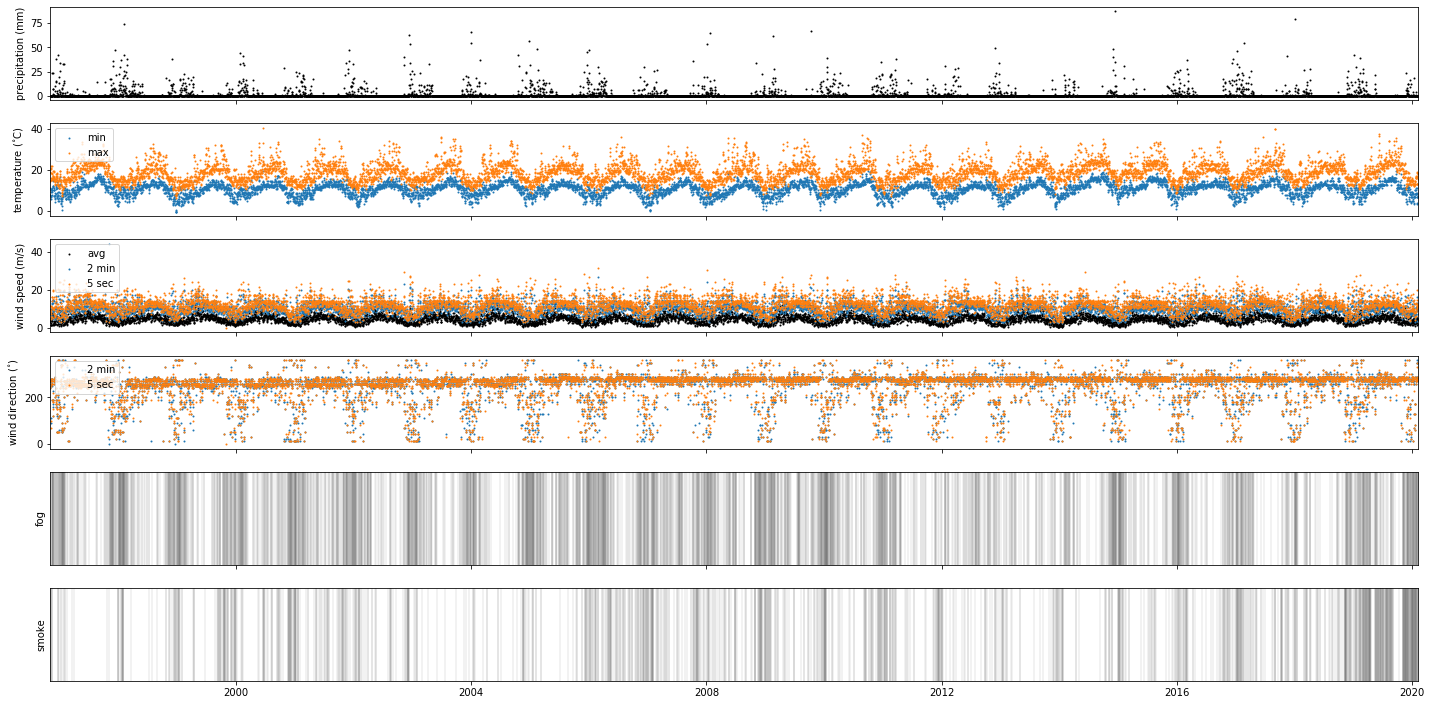

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=6, figsize=(20,10), sharex=True)

s = 1
lw = 0.1

ax[0].scatter(data_attributes['DATE'], data_features_imputed['PRCP'], c='k', s=s)
ax[0].set_ylabel('precipitation (mm)')

ax[1].scatter(data_attributes['DATE'], data_features_imputed['TMIN'], c='C0', s=s, label='min')
ax[1].scatter(data_attributes['DATE'], data_features_imputed['TMAX'], c='C1', s=s, label='max')
ax[1].set_ylabel('temperature ($^{\circ}$C)')
ax[1].legend(loc='upper left')

ax[2].scatter(data_attributes['DATE'], data_features_imputed['AWND'], c='k', s=s, label='avg')
ax[2].scatter(data_attributes['DATE'], data_features_imputed['WSF2'], c='C0', s=s, label='2 min')
ax[2].scatter(data_attributes['DATE'], data_features_imputed['WSF5'], c='C1', s=s, label='5 sec')
ax[2].set_ylabel('wind speed (m/s)')
ax[2].legend(loc='upper left')

ax[3].scatter(data_attributes['DATE'], data_features_imputed['WDF2'], c='C0', s=s, label='2 min')
ax[3].scatter(data_attributes['DATE'], data_features_imputed['WDF5'], c='C1', s=s, label='5 sec')
ax[3].set_ylabel('wind direction ($^{\circ}$)')
ax[3].legend(loc='upper left')

for date in data_attributes[data_features_imputed['WT01']==1]['DATE']:
    ax[4].axvline(date, c='k', lw=0.1)
ax[4].set_ylabel('fog')
ax[4].set_yticks([])

for date in data_attributes[data_features_imputed['WT08']==1]['DATE']:
    ax[5].axvline(date, c='k', lw=0.1)
ax[5].set_ylabel('smoke')
ax[5].set_yticks([])

ax[5].set_xlim(np.min(data_attributes['DATE']), np.max(data_attributes['DATE']))

fig.tight_layout()
plt.show(fig)

Unsurprisingly, there is a clear annual seasonal cycle in all the variables. Let's do a FFT to see this clearly:

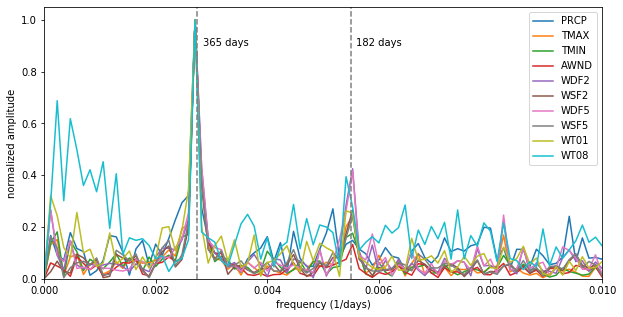

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

for feature in features:

    # subtract the mean from the data and taper it
    tukey = signal.tukey(len(data_features_imputed[feature]))
    tapered_data = (data_features_imputed[feature] - np.mean(data_features_imputed[feature])) * tukey

    # perform the fft
    yf = np.fft.rfft(data_features_imputed[feature] - np.mean(data_features_imputed[feature]))
    xf = np.fft.rfftfreq(len(data_features_imputed[feature]))

    # plot the amplitude, but in wavelength space instead of frequency
    ax.plot(xf, abs(yf)/np.max(abs(yf)), label=feature)

# plot markers for wavelengths of 182 and 365 days
ax.axvline(1/365, ls='--', c='C7')
ax.axvline(1/182, ls='--', c='C7')
ax.text(1/365 + 0.0001, 0.9, '365 days')
ax.text(1/182 + 0.0001, 0.9, '182 days')

ax.set_xlabel('frequency (1/days)')
ax.set_ylabel('normalized amplitude')
ax.set_xlim(0,0.01)
ax.set_ylim(0,1.05)
ax.legend()

plt.show()

The FFT clearly reveals this strong periodicity with a wavelength of ~365 days. In some of the features, there also appears to be a relatively weak periodicity with a wavelength of ~182 days as well.

Interestingly, for the smoke feature (WT08), we also see amplitudes at very long wavelengths (i.e. short frequencies). These amplitudes can be attributed to the recent California fires that occurred over the past few months, which introduced an unusually large amount of smoke into the area.

While strong seasonal variability is consistent among the features, do the individual values correlate well with each other? We can plot a correlation matrix to quickly determine whether this is the case:

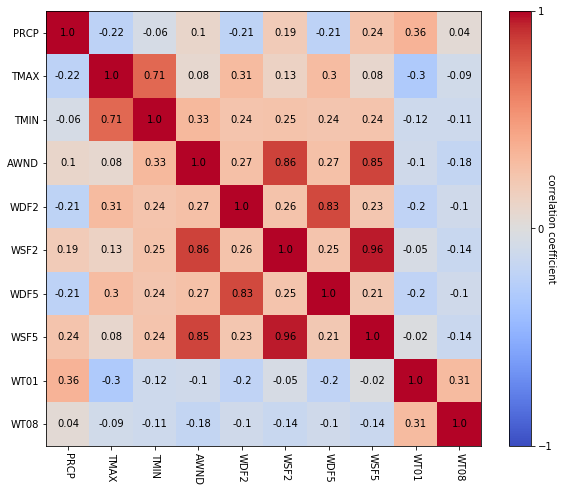

In [14]:
# calculate the correlation matrix
corr_mtx = np.corrcoef(np.transpose(data_features_imputed.values))

fig, ax = plt.subplots(figsize=(10,8))

# plot the colours
cax = ax.imshow(corr_mtx, vmin=-1, vmax=1, cmap='coolwarm')

# set the axis labels
ax.set_xticks(np.arange(0,len(data_features_imputed.columns)))
ax.set_yticks(np.arange(0,len(data_features_imputed.columns)))
ax.set_xticklabels(data_features_imputed.columns, rotation=270)
ax.set_yticklabels(data_features_imputed.columns)

# add the colorbar
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_ylabel('correlation coefficient', rotation=270)

# add text for the values
for i in range(len(data_features_imputed.columns)):
    for j in range(len(data_features_imputed.columns)):
        ax.text(i, j, str(np.round(corr_mtx[i,j],2)),
                horizontalalignment='center', verticalalignment='center')

plt.show(fig)

We see strong correlations between features that are effectively measuring variants of the same climate system component (e.g. minimum and maximum temperatures), but don't see any strong correlations (either positive or negative) between different components of the climate system.

Ultimately, this simple correlation analysis illustrates the complex non-linear behaviour of Earth's climate system, and therefore the difficulty in trying to predict future weather, even over relatively short time-scales.

But let's give it a shot anyway.

## Forecast

The following code was inspired by the TensorFlow tutorial that can be found here: https://www.tensorflow.org/tutorials/structured_data/time_series

#### Setup

For this project, let's try to forecast the minimum temperature for one week into the future (we'll refer to this window as the target window). To do so, we need to specify how many days of previous observations we will use to make this forecast (we'll refer to this window as the history window). The function below helps in the creation of these two windows.

Note that the history windows used for training make up a 3D matrix, in which the three dimensions are:
* the features
* time (over the duration of one history window)
* number of examples (where each example is one history window)

The target windows used for training make up a 2D matrix, since we're only looking to predict a single feature (minimum temperature).

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size):
    """
    Function modified from https://www.tensorflow.org/tutorials/structured_data/time_series

    Parameters
    ----------
    dataset : dataframe
        The dataframe which contains the observations.

    target : series
        The series which contains the target.

    start_index : int
        The index at which to start grabbing data.

    end_index : int
        The index at which to stop grabbing data.

    history_size : int
        The number of indexes to grab leading up to the prediction window.

    target_size : int
        The size of the prediction window.

    Returns
    -------
    data : array
        The data.

    labels : array
        The labels.
    """
    data = []
    labels = []

    # define the range of indexes that will serve as the index from which the target will be grabbed
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    # grab successive data+label windows
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

Now we need to make a few choices about how we're going to set up the model:

* size of history window
    * to begin with, let's try using half a year (i.e. 180 days)
* size of target window
    * we've already decided that we're trying to predict one week into the future (i.e. 7 days)
* train/validation split
    * since our history+target window is 187 days long, we have 8500-187 = 8313 instances that can be split into training and validation (since we slide the history+target window along from the beginning of the dataset until we run out od space)
    * let's use 7000 of these instances for training, and the rest for validation
    * note however that we want to shuffle the windows before making the training/validation split, such that we can allow the model to generalize through any long-term changes in the climate system

Let's use the function above to extract these splits:

In [0]:
# define window sizes
history_size = 180
target_size = 7

# define the split sizes
TRAIN_SPLIT = 7000

# standardize the data (using just values from the training split)
dataset = data_features_imputed.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

# extract the x and y
x_all, y_all = multivariate_data(dataset, dataset[:, 2], 0, len(data_features_imputed)-target_size, history_size, target_size)

# shuffle
p = np.random.permutation(x_all.shape[0])
x_all = x_all[p]
y_all = y_all[p]

# make the split
x_train = x_all[:TRAIN_SPLIT,:,:]
x_val = x_all[TRAIN_SPLIT:,:,:]

y_train = y_all[:TRAIN_SPLIT,:]
y_val = y_all[TRAIN_SPLIT:,:]

Check out a sample data point:

In [17]:
print('Single history window : {}'.format(x_train[0].shape))
print('Single target window  : {}'.format(y_train[0].shape))

Single history window : (180, 10)
Single target window  : (7,)


Convert into a TensorFlow `Dataset`, then batch and cache the data:

In [0]:
tf.random.set_seed(2020)

BATCH_SIZE = 256

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

Plot a sample data instance:

In [0]:
def plot_instance(ax, history, target, prediction=None):
    """
    Function modified from https://www.tensorflow.org/tutorials/structured_data/time_series

    Parameters
    ----------
    ax : axis
        The axis on which to make the plot

    history : array_like
        The history window.

    target : array_like
        The target window.

    prediction : array_like
        The model prediction of the target window.
    """
    history_x = np.arange(-len(history), 0)
    target_x = np.arange(len(target))

    ax.plot(history_x, np.array(history[:, 2]), c='C7', label='history')
    ax.plot([history_x[-1],target_x[0]],
            [np.array(history[:, 2])[-1], np.array(target)[0]],
            c='k', ls='--', label='__nolegend__')
    ax.plot(target_x, np.array(target), c='k', label='target')
    if prediction is not None:
        ax.plot([history_x[-1],target_x[0]],
                [np.array(history[:, 2])[-1], np.array(prediction)[0]],
                c='r', ls='--', label='__nolegend__')
        ax.plot(target_x, np.array(prediction), c='r', label='prediction')

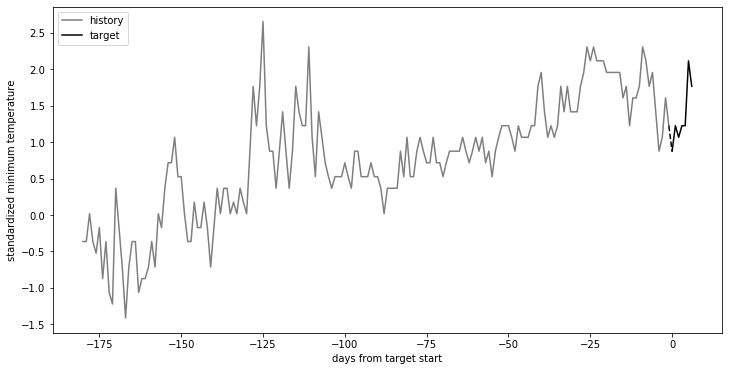

In [20]:
fig, ax = plt.subplots(figsize=(12,6))

for x, y in train_data.take(1):
    plot_instance(ax, x[0], y[0])

ax.legend(loc='upper left')
ax.set_xlabel('days from target start')
ax.set_ylabel('standardized minimum temperature')

plt.show(fig)

### Model

In [21]:
model_01 = tf.keras.models.Sequential()

model_01.add(tf.keras.layers.LSTM(64, input_shape=x_train.shape[-2:], return_sequences=True))
model_01.add(tf.keras.layers.LSTM(32, return_sequences=True))
model_01.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_01.add(tf.keras.layers.LSTM(8, activation='relu'))
model_01.add(tf.keras.layers.Dense(target_size))

model_01.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
                 loss='mae',
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 180, 64)           19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 180, 32)           12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 180, 16)           3136      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 7)                 63        
Total params: 35,615
Trainable params: 35,615
Non-trainable params: 0
_________________________________________________________________


In [22]:
EPOCHS = 10
VALIDATION_STEPS = 50
EVALUATION_INTERVAL = 200

loss0, accuracy0 = model_01.evaluate(val_data, steps=VALIDATION_STEPS)

50/50 [==============================] - 5s 92ms/step - loss: 0.8341 - root_mean_squared_error: 1.0145


In [23]:
model_01_history = model_01.fit(train_data,
                                epochs=EPOCHS,
                                steps_per_epoch=EVALUATION_INTERVAL,
                                validation_data=val_data,
                                validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 45s 224ms/step - loss: 0.5558 - root_mean_squared_error: 0.7697 - val_loss: 0.4788 - val_root_mean_squared_error: 0.6142
Epoch 2/10
200/200 [==============================] - 40s 200ms/step - loss: 0.4420 - root_mean_squared_error: 0.5847 - val_loss: 0.4422 - val_root_mean_squared_error: 0.5735
Epoch 3/10
200/200 [==============================] - 40s 202ms/step - loss: 0.4103 - root_mean_squared_error: 0.5467 - val_loss: 0.4209 - val_root_mean_squared_error: 0.5493
Epoch 4/10
200/200 [==============================] - 40s 201ms/step - loss: 0.3886 - root_mean_squared_error: 0.5208 - val_loss: 0.4114 - val_root_mean_squared_error: 0.5421
Epoch 5/10
200/200 [==============================] - 40s 199ms/step - loss: 0.3718 - root_mean_squared_error: 0.5008 - val_loss: 0.3873 - val_root_mean_squared_error: 0.5103
Epoch 6/10
200/200 [==============================] - 40s 200ms/step - loss: 0.358

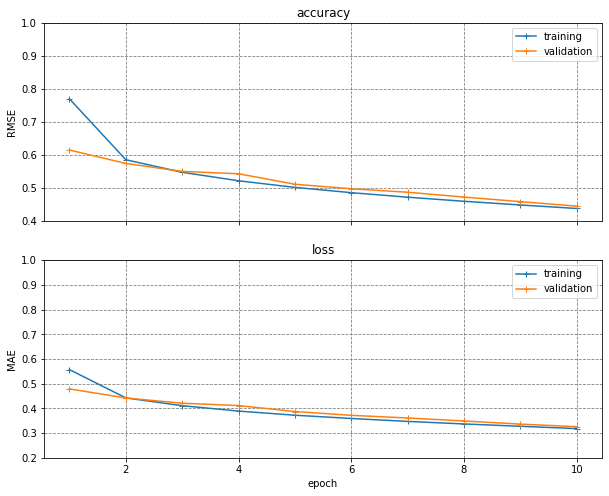

In [24]:
acc = model_01_history.history['root_mean_squared_error']
val_acc = model_01_history.history['val_root_mean_squared_error']

loss = model_01_history.history['loss']
val_loss = model_01_history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, EPOCHS+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('RMSE')
ax[0].set_ylim(0.4, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('MAE')
ax[1].set_ylim(0.2, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

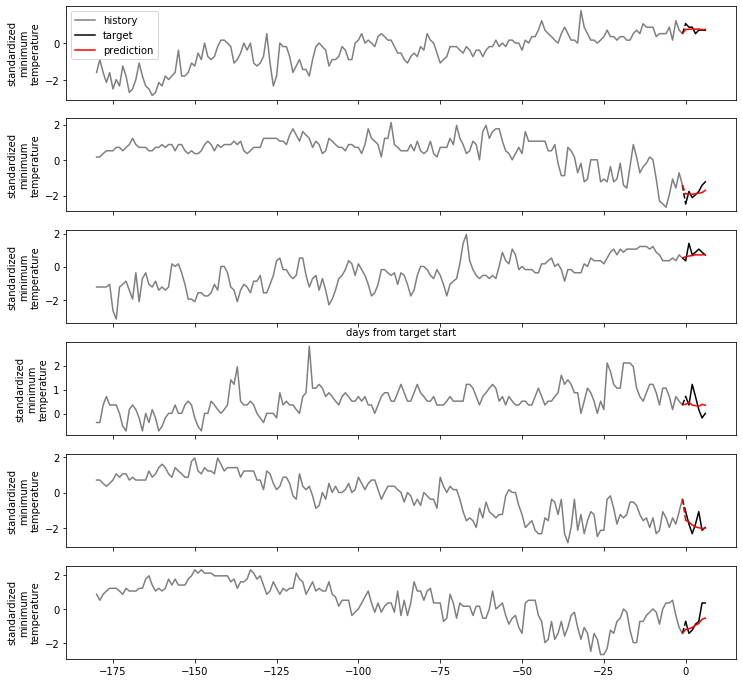

In [27]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(12,12), sharex=True)

i = 0
for x, y in val_data.take(6):
    plot_instance(ax[i], x[0], y[0], model_01.predict(x)[0])
    ax[i].set_ylabel('standardized\nminimum\ntemperature')
    i = i + 1

ax[0].legend(loc='upper left')
ax[2].set_xlabel('days from target start')

plt.show(fig)